In [22]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd


df_turkic = pd.read_csv('~/turkicPCA/turkicDefAncientScaledG25.csv', header=None)
df_all = pd.read_csv('~/turkicPCA/allAncientScaledG25.csv', header=None)


df_turkic['label'] = 1
df_all['label'] = 0


df_combined = pd.concat([df_turkic, df_all]).drop_duplicates().reset_index(drop=True)


X = df_combined.iloc[:, :-1]
y = df_combined['label']

X_numeric = X.iloc[:, 1:]


X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))

In [23]:

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


model = create_model()


In [24]:
import datetime


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.fit(train_dataset.batch(32),
          epochs=10,
          validation_data=test_dataset.batch(32),
          callbacks=[tensorboard_callback])


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.9154 - loss: 0.2027 - val_accuracy: 0.9809 - val_loss: 0.0630
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.9863 - loss: 0.0466 - val_accuracy: 0.9809 - val_loss: 0.0625
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.9863 - loss: 0.0436 - val_accuracy: 0.9809 - val_loss: 0.0638
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9863 - loss: 0.0420 - val_accuracy: 0.9809 - val_loss: 0.0653
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.9863 - loss: 0.0406 - val_accuracy: 0.9809 - val_loss: 0.0665
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.9863 - loss: 0.0395 - val_accuracy: 0.9809 - val_loss: 0.0674
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.9863 - loss: 0.0384 - val_accuracy: 0.9809 - val_loss: 0.0694
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.9863 - loss: 0.0376 - 

In [25]:

def predict_turkic_and_save_csv(csv_file, model, scaler, output_file, threshold=0.3):
    df = pd.read_csv(csv_file, header=None)
    X_new = df.iloc[:, 1:]  # Exclude non-numeric data


    X_new_scaled = scaler.transform(X_new)


    probabilities = model.predict(X_new_scaled)


    predictions_labels = ["Turkic" if prob > 0.09624789 else "Not Turkic" for prob in probabilities]


    df['Turkic_Probability'] = probabilities
    df['Prediction'] = predictions_labels


    df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")


input_csv = '~/turkicPCA/allModernScaledG25.csv'
output_csv = '~/turkicPCA/turkicPredictAllModernScaledG25.csv'
predict_turkic_and_save_csv(input_csv, model, scaler, output_csv)
input_csv = '~/turkicPCA/allAncientScaledG25.csv'
output_csv = '~/turkicPCA/turkicPredictAllAncientScaledG25.csv'
predict_turkic_and_save_csv(input_csv, model, scaler, output_csv)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predictions saved to ~/turkicPCA/turkicPredictAllModernScaledG25.csv
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step
Predictions saved to ~/turkicPCA/turkicPredictAllAncientScaledG25.csv


In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px

csv_file_path = '~/turkicPCA/turkicPredictAllAncientScaledG25.csv'

df = pd.read_csv(csv_file_path)

features = df.columns[1:25]  

tsne = TSNE(n_components=2, random_state=87)
tsne_results = tsne.fit_transform(df[features])

df['tsne-2d-one'] = tsne_results[:, 0]
df['tsne-2d-two'] = tsne_results[:, 1]

hover_name = df.columns[0]

color_map = {'Turkic': 'red', 'Not Turkic': 'blue'}  

fig = px.scatter(df, x='tsne-2d-one', y='tsne-2d-two', color='Prediction',
                 color_discrete_map=color_map, hover_name=hover_name)

fig.show()


In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px

ancient_file_path = '~/turkicPCA/turkicPredictAllAncientScaledG25.csv'
modern_file_path = '~/turkicPCA/turkicModernScaledG25.csv'

df_ancient = pd.read_csv(ancient_file_path)
df_modern = pd.read_csv(modern_file_path)

df_modern['Prediction'] = 'Modern Turkic'

df = pd.concat([df_ancient, df_modern])

# Select the features for t-SNE
features = df.columns[1:25]

tsne = TSNE(n_components=2, random_state=87)
tsne_results = tsne.fit_transform(df[features])

df['tsne-2d-one'] = tsne_results[:, 0]
df['tsne-2d-two'] = tsne_results[:, 1]

hover_name = df.columns[0]

color_map = {'Turkic': 'red', 'Not Turkic': 'blue', 'Modern Turkic': 'yellow'}

fig = px.scatter(df, x='tsne-2d-one', y='tsne-2d-two', color='Prediction',
                 color_discrete_map=color_map, hover_name=hover_name)

fig.show()


In [28]:
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np

ancient_file_path = '~/turkicPCA/turkicPredictAllAncientScaledG25.csv'
modern_file_path = '~/turkicPCA/turkicModernScaledG25.csv'

df_ancient = pd.read_csv(ancient_file_path)
df_modern = pd.read_csv(modern_file_path)

df_modern['Prediction'] = 'Modern Turkic'

df = pd.concat([df_ancient, df_modern])

features = df.columns[1:25]

tsne = TSNE(n_components=2, random_state=87)
tsne_results = tsne.fit_transform(df[features])

df['tsne-2d-one'] = tsne_results[:, 0]
df['tsne-2d-two'] = tsne_results[:, 1]

def determine_color(row):
    if row['Prediction'] == 'Modern Turkic':
        return 'yellow'
    elif row['Turkic_Probability'] < 0.04:
        return 'black'
    else:
        max_prob = df.loc[df['Prediction'] == 'Not Turkic', 'Turkic_Probability'].max()
        min_prob = df.loc[df['Prediction'] == 'Not Turkic', 'Turkic_Probability'].min()
        norm_prob = (row['Turkic_Probability'] - min_prob) / (max_prob - min_prob)
        red_intensity = int(255 * norm_prob)
        return f'rgb({red_intensity},0,0)'

df['color'] = df.apply(determine_color, axis=1)

hover_name = df.columns[0]

fig = px.scatter(df, x='tsne-2d-one', y='tsne-2d-two',
                 color='color', color_discrete_map="identity",
                 hover_name=hover_name)

fig.show()


In [29]:
import os

output_file_path = os.path.expanduser('~/turkicPCA/turkic_tsne_plot.html')

fig.write_html(output_file_path)

print(f"Plot saved to {output_file_path}")


Plot saved to /Users/asami/turkicPCA/turkic_tsne_plot.html


In [30]:
# PCA Visualization
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df[features])
df['pca-one'] = pca_results[:, 0]
df['pca-two'] = pca_results[:, 1]

# Plot PCA
fig_pca = px.scatter(df, x='pca-one', y='pca-two', color='color', color_discrete_map="identity", hover_name=df.columns[0])
fig_pca.show()


In [40]:
# UMAP Visualization
from umap import UMAP

# Perform UMAP
umap = UMAP(n_components=2, random_state=87)
umap_results = umap.fit_transform(df[features])
df['umap-one'] = umap_results[:, 0]
df['umap-two'] = umap_results[:, 1]

# Plot UMAP
fig_umap = px.scatter(df, x='umap-one', y='umap-two', color='color', color_discrete_map="identity", hover_name=df.columns[0])
fig_umap.show()


/Users/asami/turkicPCA/venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Matplotlib is building the font cache; this may take a moment.


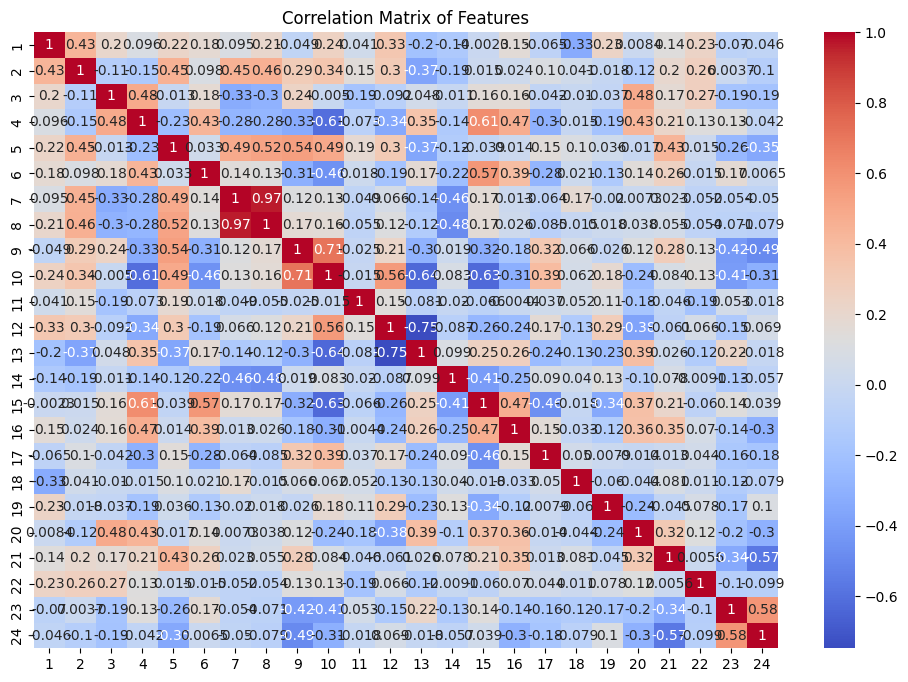

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df[features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()
